In [102]:
import numpy as np
import matplotlib.pyplot as plt
from SpringMassSystem import SpringMassSystem
import scipy.integrate as integrate
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# initialize the SpringMass model

ndim = 2          # choose between 1D (ndim=1) or 2D (ndim=2) system
N_m = 5           # number of nodes
L0 = 7            # springs' rest length (m)
k0 = 70           # spring stiffness (f = k*dx) (N/m)
m0 = 1            # node mass (kg)

model = SpringMassSystem(ndim, N_m, L0, k0, m0)
# model.initialize_as_caternary()

In [104]:
# solve the model ODE

dt = 0.01         # set evaluation timestep (this sets the solver's max stepsize)
t_eval = np.arange(0,20,dt)

sol = integrate.solve_ivp(
    fun=model.compute_augmented_xdot, 
    t_span=[t_eval[0], t_eval[-1]], 
    t_eval=t_eval,
    y0=model.get_initial_X_aug(), 
    method='RK45',)

# solution data - times, positions, velocities
t = sol.t
X_t = np.reshape(sol.y[:N_m * ndim,:], (N_m,-1,len(t)))
Xdot_t = np.reshape(sol.y[N_m * ndim:,:], (N_m,-1,len(t)))

In [105]:
Xddot_t = []
for i, _ in enumerate(t):
    Xddot_t.append(model.compute_Xddot(X_t[:,:,i])[:,:,np.newaxis])

Xddot_t = np.concatenate(Xddot_t, axis=2)

X_ends_t = np.concatenate((
    np.kron(np.ones((1,len(t))), model.xL.T)[np.newaxis,:,:],
    np.kron(np.ones((1,len(t))), model.xR.T)[np.newaxis,:,:]
)).reshape((-1, len(t)))

In [106]:
# tmp = np.concatenate((X_t,Xdot_t),axis=1).reshape((-1, len(t)))

# for mass_id in range(Xdot_t.shape[0]):
#     for ax in range(Xdot_t.shape[1]):
#         ax_labels = ['x','y']
#         # positions        
#         assert(np.allclose(X_t[mass_id,ax,:], tmp[mass_id*4 + ax,:]))
#         # velocities
#         assert(np.allclose(Xdot_t[mass_id,ax,:], tmp[mass_id*4 + ax + 2,:]))

import pandas as pd

data_matrix = np.concatenate((X_t, Xdot_t, Xddot_t),axis=1).reshape((-1, len(t)))
data_matrix = np.concatenate((t[np.newaxis,:], data_matrix), axis=0)
data_matrix = np.concatenate((data_matrix, X_ends_t), axis=0)

col_labels = ['t']
label_types = ['r', 'rdot', 'rddot']
dims = ['x','y','z']
dims = dims[:ndim]

for mass_idx in range(N_m):
    for label in label_types:
        for dim in dims:
            col_labels.append(label + str(mass_idx) + '_' + str(dim))

for dim in dims:
    col_labels += ['rLeft_' + str(dim)]

for dim in dims:
    col_labels += ['rRight_' + str(dim)]

            
pd.DataFrame(data=data_matrix.T, columns=col_labels).to_csv("k=70_L=7.csv", index=False)

<IPython.core.display.Javascript object>


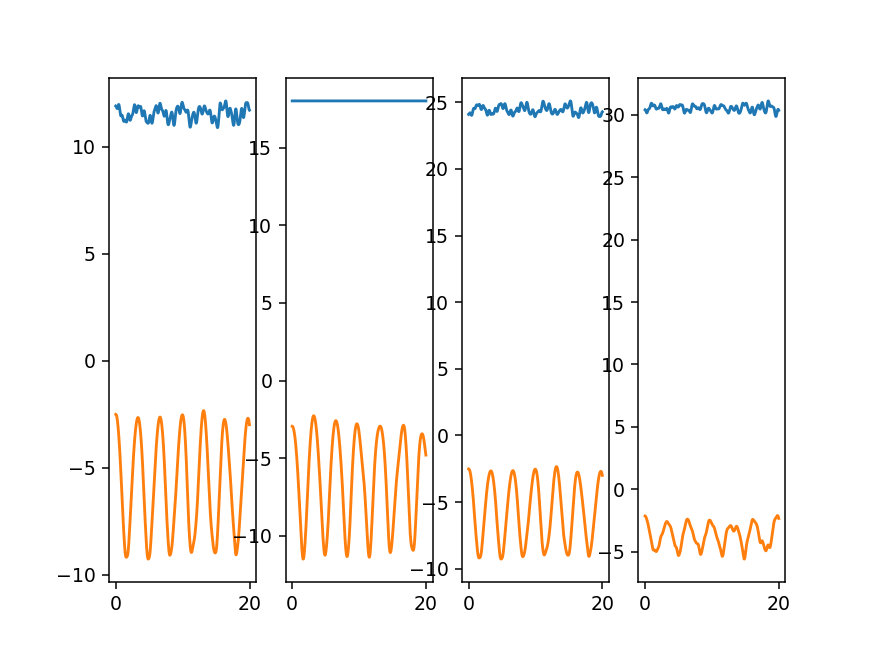

In [89]:
num_plots = min(N_m, 4)
fig, axs = plt.subplots(1, num_plots)
for i in range(num_plots):
    axs[i].plot(t, X_t[i+1,:,:].T)

<IPython.core.display.Javascript object>


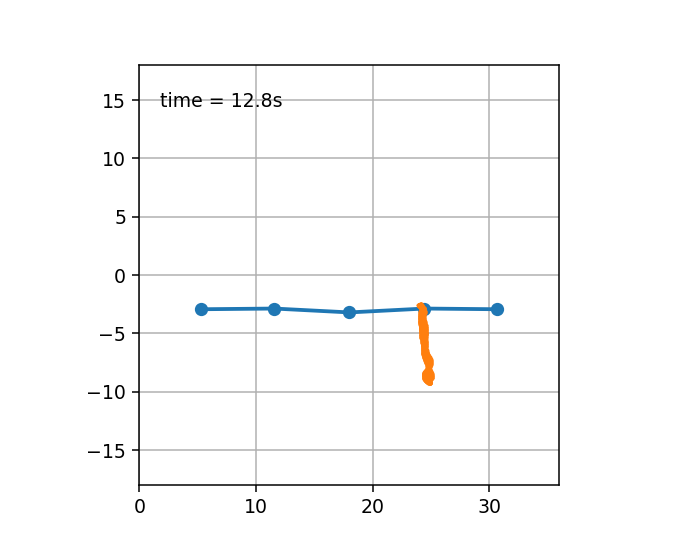

In [90]:
import matplotlib.animation as animation
from collections import deque

history_len = len(t)  # how many trajectory points to display

L = L0 * (N_m // 2) * 1.5
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False, xlim=(-L + L0*(N_m+1)/2, L + L0*(N_m+1)/2), ylim=(-L, L))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], '.-', lw=1, ms=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
history_x, history_y = deque(maxlen=history_len), deque(maxlen=history_len)


def animate(i):
    thisx = X_t[:, 0, i]
    if ndim == 1:
        thisy = np.zeros_like(thisx)
    else:
        thisy = X_t[:, 1, i]

    if i == 0:
        history_x.clear()
        history_y.clear()

    history_x.appendleft(thisx[1 + (N_m // 2)])
    history_y.appendleft(thisy[1 + (N_m // 2)])

    line.set_data(thisx, thisy)
    trace.set_data(history_x, history_y)
    time_text.set_text(time_template % (i*dt))
    return line, trace, time_text


ani = animation.FuncAnimation(
    fig, animate, len(t), interval=dt*1000, blit=True)
plt.show()